In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('titanic (2).csv')

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [8]:
features_dr=['Name','Cabin']
df=df.drop(features_dr,axis=1)

In [9]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

In [10]:
df['Sex_binary'] = df['Sex'].map({'male': 0, 'female': 1})

In [11]:
features = ['Pclass', 'Sex_binary', 'Age', 'SibSp', 'Parch', 'Fare']
X = df[features].values
y = df['Survived'].values

In [12]:
X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [13]:
def manual_pca(X, n_components=3):
    cov_matrix = np.cov(X.T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = eigenvalues.argsort()[::-1]
    components = eigenvectors[:, idx[:n_components]]
    return np.dot(X, components)

In [14]:
X_pca = manual_pca(X_std, n_components=3)
#pca complete

In [15]:
y_svm = np.where(y == 0, -1, 1)

In [16]:
def train_svm(X, y, lr=0.001, lambda_param=0.01, epochs=1000):
    weights = np.zeros(X.shape[1])
    bias = 0
    cost_history=[]
    for _ in range(epochs):
        distances = y * (np.dot(X, weights) - bias)
        hinge_loss = np.maximum(0, 1 - distances)
        cost = lambda_param * np.dot(weights, weights) + np.mean(hinge_loss)
        cost_history.append(cost)
        for idx, x_i in enumerate(X):
            # Hinge Loss Condition
            condition = y[idx] * (np.dot(x_i, weights) - bias) >= 1
            if condition:
                weights -= lr * (2 * lambda_param * weights)
            else:
                weights -= lr * (2 * lambda_param * weights - np.dot(x_i, y[idx]))
                bias -= lr * y[idx]
    return weights, bias , cost_history
def get_confusion_matrix(actual, predicted):
    tp = np.sum((actual == 1) & (predicted == 1))
    tn = np.sum((actual == -1) & (predicted == -1))
    fp = np.sum((actual == -1) & (predicted == 1))
    fn = np.sum((actual == 1) & (predicted == -1))

    return np.array([[tn, fp], [fn, tp]])

In [17]:
indices = np.random.permutation(len(X_pca))
train_idx, test_idx = indices[:int(len(X)*0.8)], indices[int(len(X)*0.8):]
X_train, X_test = X_pca[train_idx], X_pca[test_idx]
y_train, y_test = y_svm[train_idx], y_svm[test_idx]

In [18]:
w, b, svm_cost_history = train_svm(X_train, y_train)

In [19]:
y_pred = np.sign(np.dot(X_test, w) - b)
accuracy = np.mean(y_pred == y_test)

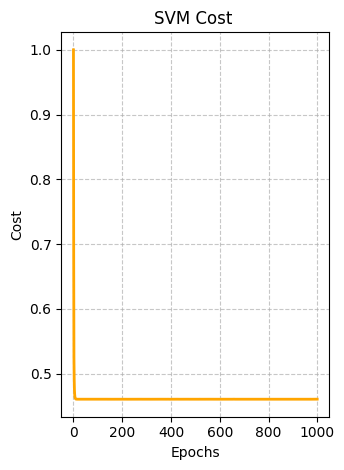

In [20]:
plt.subplot(1, 2, 2)
plt.plot(svm_cost_history, color='orange', linewidth=2)
plt.title('SVM Cost ')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [24]:
cm = get_confusion_matrix(y_test, y_pred)

In [25]:
print(f"SVM Accuracy with 3 PCA Components: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(f"                     Predicted 0    Predicted 1")
print(f"Actual 0 (Died)      {cm[0,0]:<14} {cm[0,1]}")
print(f"Actual 1 (Survived)  {cm[1,0]:<14} {cm[1,1]}")

SVM Accuracy with 3 PCA Components: 82.68%

Confusion Matrix:
                     Predicted 0    Predicted 1
Actual 0 (Died)      95             12
Actual 1 (Survived)  19             53


In [26]:
indices = np.random.permutation(len(X_std))
train_idx, test_idx = indices[:int(len(X)*0.8)], indices[int(len(X)*0.8):]
X_train, X_test = X_std[train_idx], X_std[test_idx]
y_train, y_test = y_svm[train_idx], y_svm[test_idx]

In [27]:
w, b, svm_cost_history = train_svm(X_train, y_train)

In [28]:
y_pred = np.sign(np.dot(X_test, w) - b)
accuracy = np.mean(y_pred == y_test)

In [29]:
print(f"SVM Accuracy without PCA: {accuracy * 100:.2f}%")
print("\nConfusion Matrix:")
print(f"                     Predicted 0    Predicted 1")
print(f"Actual 0 (Died)      {cm[0,0]:<14} {cm[0,1]}")
print(f"Actual 1 (Survived)  {cm[1,0]:<14} {cm[1,1]}")

SVM Accuracy without PCA: 79.89%

Confusion Matrix:
                     Predicted 0    Predicted 1
Actual 0 (Died)      95             12
Actual 1 (Survived)  19             53


In [53]:
def sigmoid(z):
    # Standard mathematical sigmoid function: 1 / (1 + e^-z)
    return 1 / (1 + np.exp(-z.astype(float)))

def compute_cost(y, h):
    # Added epsilon to prevent log(0) errors which cause NaN costs
    epsilon = 1e-15
    return -np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

def train_logistic_model(X, y, lr=0.1, epochs=2000):
    # Add intercept (bias) term to X
    X_intercept = np.c_[np.ones(X.shape[0]), X]
    weights = np.zeros(X_intercept.shape[1])
    cost_history = []

    for _ in range(epochs):
        z = np.dot(X_intercept, weights)
        h = sigmoid(z)
        # Gradient descent update rule
        gradient = np.dot(X_intercept.T, (h - y)) / y.size
        weights -= lr * gradient
        cost_history.append(compute_cost(y, h))
    return weights, cost_history

def predict_logistic(X, weights):
    X_intercept = np.c_[np.ones(X.shape[0]), X]
    # Classify as 1 if probability is >= 0.5, else 0
    return (sigmoid(np.dot(X_intercept, weights)) >= 0.5).astype(int)

In [54]:
y_train_log = np.where(y_train == -1, 0, 1)
y_test_log = np.where(y_test == -1, 0, 1)

In [55]:
weights_pca, cost_pca = train_logistic_model(X_train, y_train_log)
preds_pca = predict_logistic(X_test, weights_pca)
acc_pca = np.mean(preds_pca == y_test_log)

In [56]:
indices = np.random.permutation(len(X_std))
train_size = int(len(X_std) * 0.8)
X_train_std = X_std[indices[:train_size]]
X_test_std = X_std[indices[train_size:]]
y_train_std = y[indices[:train_size]]
y_test_std = y[indices[train_size:]]

In [57]:
weights_std, cost_std = train_logistic_model(X_train_std, y_train_std)
preds_std = predict_logistic(X_test_std, weights_std)
acc_std = np.mean(preds_std == y_test_std)

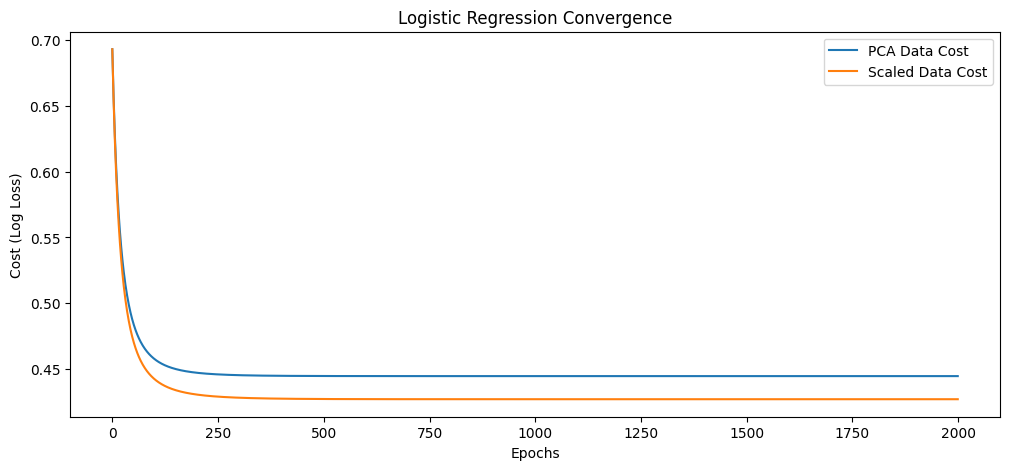

In [58]:
plt.figure(figsize=(12, 5))
plt.plot(cost_pca, label='PCA Data Cost')
plt.plot(cost_std, label='Scaled Data Cost')
plt.title('Logistic Regression Convergence')
plt.xlabel('Epochs')
plt.ylabel('Cost (Log Loss)')
plt.legend()
plt.show()

In [60]:
print(f"Logistic Regression Accuracy (PCA 3-Components): {acc_pca * 100:.2f}%")

Logistic Regression Accuracy (PCA 3-Components): 78.21%


In [61]:
print(f"Logistic Regression Accuracy (Full Scaled Data): {acc_std * 100:.2f}%")

Logistic Regression Accuracy (Full Scaled Data): 73.74%
